# Purpose

This notebook is designed to help team members understand the files of the dataset. This includes audio files, eeg files (and their associated vhdr and metadata files), and the provided preprocessing files.

# Imports

In [ ]:
!pip install mne transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 50.3 MB/s eta 0:00:00


In [ ]:
### Torch
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
from    torch.optim import lr_scheduler
from    torch.utils.data import Dataset, DataLoader
import  torchaudio
import  torchaudio.transforms as tat

### General
import  random
import  numpy as np
import  pandas as pd
import  pickle
import  scipy
import  gc
from    tqdm.notebook import tqdm
import  os
import  datetime
import  time
import  matplotlib.pyplot as plt
import  seaborn as sns

# wav2vec2 and EEG processing
from    transformers import (AutoProcessor, AutoModelForPreTraining,
                             CLIPProcessor, CLIPModel)

import  mne

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Config and Global Vars

In [ ]:
DATA_PATH  = '/content/gdrive/MyDrive/11785-IDLf23/Final project/0_Data'
BRAIN_PATH = '/content/gdrive/MyDrive/11785-IDLf23/Final project/0_Data/brennan_and_hale_v2'
AUDIO_PATH = '/content/gdrive/MyDrive/11785-IDLf23/Final project/0_Data/brennan_and_hale_v2/audio'
PPROC_PATH = '/content/gdrive/MyDrive/11785-IDLf23/Final project/0_Data/brennan_and_hale_v2/proc/timelock-preprocessing'
EMBED_PATH = '/content/gdrive/MyDrive/11785-IDLf23/Final project/0_Data/brennan_wav2vec2_embeddings'

PRETRAINED_PATH = '/content/gdrive/MyDrive/11785-IDLf23/Final project/pretrained-models'

# Dataset Description

[Dataset](https://deepblue.lib.umich.edu/data/concern/data_sets/bn999738r?locale=en#read_me_display). Brennan, J. R., & Hale, J. T. (2019). Hierarchical structure guides rapid linguistic predictions during naturalistic listening. PLoS ONE 14(1). e0207741.

The [Meta github repo for the Brennan dataset](https://github.com/facebookresearch/brainmagick/blob/main/bm/studies/brennan2019.py) has potentially helpful code, but it should be checked to confirm it all makes sense.


## utils

In [ ]:
def list_sorted_filtered_paths(root=BRAIN_PATH, ending_with='vhdr'):
    return sorted([os.path.join(root, fname) for fname in os.listdir(root) if fname.endswith(ending_with)])

print(list_sorted_filtered_paths(BRAIN_PATH, ending_with='.vhdr')[:1])
print(list_sorted_filtered_paths(AUDIO_PATH, ending_with='.wav')[:1])

['/content/gdrive/MyDrive/11785-IDLf23/Final project/0_Data/brennan_and_hale_v2/S01.vhdr']
['/content/gdrive/MyDrive/11785-IDLf23/Final project/0_Data/brennan_and_hale_v2/audio/DownTheRabbitHoleFinal_SoundFile1.wav']


## usable eeg files

In [ ]:
datasets = scipy.io.loadmat(
    os.path.join(BRAIN_PATH, 'datasets.mat'),
    squeeze_me=True,
    chars_as_strings=True,
    struct_as_record=True,
    simplify_cells=True,
)
datasets

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Nov 20 12:10:49 2018',
 '__version__': '1.0',
 '__globals__': [],
 'high_noise': array(['S02.mat', 'S28.mat', 'S29.mat', 'S31.mat', 'S33.mat', 'S46.mat',
        'S47.mat', 'S49.mat'], dtype=object),
 'low_perf': array(['S07.mat', 'S09.mat', 'S23.mat', 'S24.mat', 'S27.mat', 'S30.mat',
        'S32.mat', 'S43.mat'], dtype=object),
 'use': array(['S01.mat', 'S03.mat', 'S04.mat', 'S05.mat', 'S06.mat', 'S08.mat',
        'S10.mat', 'S11.mat', 'S12.mat', 'S13.mat', 'S14.mat', 'S15.mat',
        'S16.mat', 'S17.mat', 'S18.mat', 'S19.mat', 'S20.mat', 'S21.mat',
        'S22.mat', 'S25.mat', 'S26.mat', 'S34.mat', 'S35.mat', 'S36.mat',
        'S37.mat', 'S38.mat', 'S39.mat', 'S40.mat', 'S41.mat', 'S42.mat',
        'S44.mat', 'S45.mat', 'S48.mat'], dtype=object)}

In [ ]:
USABLE_EEG = [fname.replace('.mat', '') for fname in datasets['use']]

# S26, S34, S35, S36 missing the start for Segment 1
USABLE_EEG.remove('S26')
USABLE_EEG.remove('S34')
USABLE_EEG.remove('S35')
USABLE_EEG.remove('S36')
print(len(USABLE_EEG))
print(USABLE_EEG)

29
['S01', 'S03', 'S04', 'S05', 'S06', 'S08', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S25', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S44', 'S45', 'S48']


## sensor location info

In [ ]:
def read_sfp(file_path):
    electrodes = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()  # Split by whitespace
            if len(parts) == 4:
                # Parse the electrode name and coordinates
                name = parts[0]
                x, y, z = map(float, parts[1:])  # Convert strings to floats
                electrodes[name] = (x, y, z)
    return electrodes

# Replace 'path_to_your_file.sfp' with the path to your SFP file
electrode_positions = read_sfp(os.path.join(BRAIN_PATH, 'easycapM10-acti61_elec.sfp'))
print(electrode_positions)


{'1': (0.0, 3.517, 8.285), '2': (3.045, 1.758, 8.285), '3': (3.045, -1.758, 8.285), '4': (0.0, -3.517, 8.285), '5': (-3.045, -1.758, 8.285), '6': (-3.045, 1.758, 8.285), '7': (0.0, 8.345, 3.371), '8': (3.394, 7.623, 3.371), '9': (6.201, 5.584, 3.371), '10': (7.936, 2.579, 3.371), '11': (8.299, -0.872, 3.371), '12': (7.227, -4.172, 3.371), '13': (4.905, -6.751, 3.371), '14': (1.735, -8.162, 3.371), '15': (-1.735, -8.162, 3.371), '16': (-4.905, -6.751, 3.371), '17': (-7.227, -4.172, 3.371), '18': (-8.299, -0.872, 3.371), '19': (-7.936, 2.579, 3.371), '20': (-6.201, 5.584, 3.371), '21': (-3.394, 7.623, 3.371), '22': (6.786, 4.752, -3.517), '23': (8.159, 1.439, -3.517), '24': (8.002, -2.144, -3.517), '25': (6.346, -5.325, -3.517), '26': (3.501, -7.508, -3.517), '27': (0.0, -8.285, -3.517), '28': (-3.501, -7.508, -3.517), '29': (-6.346, -5.325, -3.517), '30': (-8.002, -2.144, -3.517), '31': (-8.159, 1.439, -3.517), '32': (-6.786, 4.752, -3.517), '33': (0.0, 0.0, 9.0), '34': (0.0, 6.364, 6.3

## alice chapter

In [ ]:
alice_chapter_1 = pd.read_csv(os.path.join(BRAIN_PATH, 'AliceChapterOne-EEG.csv'), header=0)
alice_chapter_1.head()

,Word,Segment,onset,offset,Order,LogFreq,LogFreq_Prev,LogFreq_Next,SndPower,Length,Position,Sentence,IsLexical,NGRAM,RNN,CFG
0,Alice,1,0.046000,0.608721,1,8.65,0.00,14.56,3.621500e-07,0.562721,1,1,1.0,3.226499,3.126175,2.312348
1,was,1,0.562721,0.830543,2,14.56,8.65,10.69,3.843500e-09,0.267822,2,1,0.0,0.905229,1.691128,1.357460
2,beginning,1,0.784543,1.302929,3,10.69,14.56,16.35,3.686500e-09,0.518386,3,1,1.0,4.446766,4.100771,5.626722
3,to,1,1.256929,1.398925,4,16.35,10.69,13.79,3.969700e-09,0.141996,4,1,0.0,2.537495,3.833313,5.939201
4,get,1,1.352925,1.662327,5,13.79,16.35,13.28,3.774700e-09,0.309402,5,1,0.0,1.023137,1.013076,2.697304


## audio

### wav2vec2

Check out the authors' [Jupyter Notebook](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_Tune_XLSR_Wav2Vec2_on_Turkish_ASR_with_%F0%9F%A4%97_Transformers.ipynb) for direction on how to use it.

Also consider using [wav2vec2 english](https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english).

In the Meta code, you will find reference to wav2vec2 in the `./bm/features/audio.py` file [here](https://github.com/facebookresearch/brainmagick/blob/936b38c1db1154f1459930d1824db0f0b23762ed/bm/features/audio.py).

In [ ]:
import  torch
from    transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2Tokenizer

LANG_ID     = "en"
MODEL_ID    = "jonatasgrosman/wav2vec2-large-xlsr-53-english"

processor   = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model       = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)
tokenizer   = Wav2Vec2Tokenizer.from_pretrained(MODEL_ID)

final_layer = model.lm_head

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
Y

In [ ]:
torch.save(final_layer, os.path.join(PRETRAINED_PATH, f'wav2vec2-final-layer.pkl'))
torch.save(processor, os.path.join(PRETRAINED_PATH, f'wav2vec2-processor.pkl'))
torch.save(tokenizer, os.path.join(PRETRAINED_PATH, f'wav2vec2-tokenizer.pkl'))

### save embeddings to drive

In [ ]:
# import pickle

# for i in tqdm(range(1, 13)):
#     fpath = os.path.join(AUDIO_PATH, f'DownTheRabbitHoleFinal_SoundFile{i}.wav')
#     waveform, sample_rate = torchaudio.load(fpath)

#     if sample_rate != 16_000:
#         resampler = tat.Resample(orig_freq=sample_rate, new_freq=16_000)
#         waveform = resampler(waveform)
#         sample_rate = 16_000

#     inputs = processor(waveform, sampling_rate=sample_rate, return_tensors="pt", padding=True)

#     with torch.no_grad():
#         output = model(
#             inputs['input_values'].squeeze(0),
#             attention_mask=inputs['attention_mask'],
#             output_hidden_states=True
#         )
#     fname = os.path.join(EMBED_PATH, f'audio-{i}.pkl')
#     torch.save(output, fname)

#     print(f'Saved audio-{i}, shape = {output.hidden_states[-1].shape}')

In [ ]:
# from transformers import Wav2Vec2Tokenizer

# tokenizer = Wav2Vec2Tokenizer.from_pretrained(MODEL_ID)
# predicted_ids = output_2.logits.argmax(dim=-1)
# transcription = tokenizer.batch_decode(predicted_ids)
# print(transcription)

In [ ]:
# r = torch.rand(1, 41, 1024)
# rr = model.lm_head(r)

# predicted_ids = rr.argmax(dim=-1)
# transcription = tokenizer.batch_decode(predicted_ids)
# print(transcription)

```
audio: List[12 wav files]

eeg:   List[33 usable EEG files]

meta   csv of words

embed_dim = 1024

training_example: {(subject_id, segment_id), (wav2vec2_embedding, eeg_input)}

batch:
  - batched_eeg_input=(B, T_eeg, sensor_channels),
  - batched_wav2_vec_embedding=(B, T_audio, embed_dim)

batched_eeg_embedding = model(batched_eeg_input)
where batched_eeg_embedding is shape (B, T_eeg, embed_dim)

Y, Z = interpolate(batched_wav2_vec_embedding, batched_eeg_embedding)
Y is shape (B, T, embed_dim)
Z is shape (B, T, embed_dim)

clip(Y, Z)

```


In [ ]:
import math

vars = ['Word', 'Segment', 'Order', 'onset', 'offset']

sample_rate = 16_000

alice = alice_chapter_1[vars]
alice['start'] = np.floor(alice['onset'] * sample_rate).astype(int)
alice['stop']  = np.ceil(alice['offset'] * sample_rate).astype(int)
alice.head()

<ipython-input-14-4142f01e5ea5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alice['start'] = np.floor(alice['onset'] * sample_rate).astype(int)
<ipython-input-14-4142f01e5ea5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alice['stop']  = np.ceil(alice['offset'] * sample_rate).astype(int)


,Word,Segment,Order,onset,offset,start,stop
0,Alice,1,1,0.046000,0.608721,735,9740
1,was,1,2,0.562721,0.830543,9003,13289
2,beginning,1,3,0.784543,1.302929,12552,20847
3,to,1,4,1.256929,1.398925,20110,22383
4,get,1,5,1.352925,1.662327,21646,26598


## eeg

According to [MNE Documentation](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html), `.eeg` files can be read using `mne.io.read_raw_brainvision(vhdr_fname)`. We can try this out on file `S10.eeg` using the `S10.vhdr` header file.

This returns a `mne.io.Raw` file ([documentation here](https://mne.tools/stable/generated/mne.io.Raw.html)). See below for an illustration of some of this object's attributes.

You can also slice into the `mne.io.Raw` objects, which returns tuples of NumPy arrays.

The data is of shape `(n_channels, n_times)`. You can slice into that as you would a NumPy array.

Each file has 62 channels, one of which is VEOG (which captures vertical eye movement) and one of which is AUD/Aux5 (which captures audio).

In [ ]:
# Load EEG from VHDR
sample_vhdr = os.path.join(BRAIN_PATH, 'S26.vhdr')
example_eeg = mne.io.read_raw_brainvision(sample_vhdr, verbose=False)
print(type(example_eeg))

# Look at attributes
print(f"N Times: {example_eeg.n_times}")
print(f"Ch Names (# = {len(example_eeg.ch_names)}), e.g.: {example_eeg.ch_names[:5]}...{example_eeg.ch_names[-5:]}")
print(f"Times[:5]: {example_eeg.times[:10]}")

# CHeck shape of original data
print(f"Slice shape: {example_eeg[:,:][0].shape}")

# Select slice
eeg_slice = example_eeg[:3, :5]

# EEG data from the first 3 channels and first 5 time instants
print("\nEEG Data[3 ch, 5 times]:")
print(eeg_slice[0])
print(type(eeg_slice[0]))

# Time stamps from the first 3 channels and first 5 time instants
print("\nTime stamps:")
print(eeg_slice[1])
print(type(eeg_slice[1]))

<class 'mne.io.brainvision.brainvision.RawBrainVision'>
N Times: 363325
Ch Names (# = 62), e.g.: ['1', '2', '3', '4', '5']...['59', '60', '61', 'VEOG', 'AUD']
Times[:5]: [0.    0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018]
Slice shape: (62, 363325)

EEG Data[3 ch, 5 times]:
[[-0.01652612 -0.01652617 -0.01651699 -0.01652695 -0.01653169]
 [-0.01281763 -0.01281748 -0.01280566 -0.01281484 -0.01282153]
 [-0.02089487 -0.02089419 -0.02088428 -0.02089355 -0.02089888]]
<class 'numpy.ndarray'>

Time stamps:
[0.    0.002 0.004 0.006 0.008]
<class 'numpy.ndarray'>


### separate epochs

In [ ]:
def get_slicers(raw, events):

    slicers = {}
    end_time = raw.n_times
    for i in range(events.shape[0]):
        if i == 0:
            continue
        start = events[i, 0]
        if i + 1 == events.shape[0]:
            end = end_time
        else:
            end = events[i+1, 0]
        slicers[i] = (start, end)

    return slicers

def slice_eeg(subject_id):

    vhdr = os.path.join(BRAIN_PATH, f'{subject_id}.vhdr')
    raw = mne.io.read_raw_brainvision(vhdr, verbose=False, preload=True)
    ch_names = raw.info['ch_names']

    print(f"Working on subject {subject_id}, nchan = {raw.info['nchan']}")

    # vertical EOG
    assert ch_names[60] == "VEOG"

    # audio channel (Pad with channel if needed)
    if len(ch_names) == 61 and (('AUD' not in ch_names) or ('Aux5' not in ch_names)):
        add_audio_chan = True
        raw = mne.add_reference_channels(raw, 'AUD', copy=True)
        print(f"Now there are {raw.info['ch_names']} channels")

    for i in range(1, 13):

        # Segment events based on annotations
        events, event_ids = mne.events_from_annotations(raw, verbose=False)

        # Get slicers
        slicers = get_slicers(raw, events)

        # Get start/end for segment i, add to dict
        start, end = slicers[i]
        segment = raw[:, start:end][0]

        # Save to drive
        # with open(os.path.join(DATA_PATH, 'eeg-segments', f'{subject_id}-{i}.pkl'), 'wb') as f:
        #     pickle.dump(segment, f)
        np.save(os.path.join(DATA_PATH, 'eeg-segments', f'{subject_id}-{i}'), segment)

        del segment

def get_eeg(usable_subject_ids):

    for subject_id in tqdm(usable_subject_ids):

        slice_eeg(subject_id)

In [ ]:
all_segments = get_eeg(USABLE_EEG)

  0%|          | 0/29 [00:00<?, ?it/s]

Working on subject S01, nchan = 62
Working on subject S03, nchan = 62
Working on subject S04, nchan = 62
Working on subject S05, nchan = 61
Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
Now there are ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', 'VEOG', 'AUD'] channels
Working on subject S06, nchan = 62
Working on subject S08, nchan = 62
Working on subject S10, nchan = 62
Working on subject S11, nchan = 62
Working on subject S12, nchan = 62
Working on subject S13, nchan = 62
Working on subject S14, nchan = 62
Working on subje

In [ ]:
def check_items(dictionary):
    for k, v in dictionary.items():
        k_pretty = f'{k:<12}'
        v_pretty = f'{str(type(v)):<24}'
        if isinstance(v, dict):
            print('-'*80)
            print(k_pretty, v_pretty, v.keys(), sep='\t')
            check_items(v)
        elif isinstance(v, np.ndarray):
            if np.max(v.shape) < 10:
                print(k_pretty, v_pretty, v.shape, v, sep='\t')
            else:
                print(k_pretty, v_pretty, v.shape, v[0], sep='\t')
        else:
            print(k_pretty, v_pretty, v, sep='\t')

In [ ]:
vhdr = os.path.join(BRAIN_PATH, f'S05.vhdr')
raw = mne.io.read_raw_brainvision(vhdr, verbose=False)
print(raw.info['ch_names'])
print(raw.info)

example_proc = scipy.io.loadmat(
    os.path.join(PPROC_PATH, 'S05.mat'),
    squeeze_me=True,
    chars_as_strings=True,
    struct_as_record=True,
    simplify_cells=True,
)

print("Checking Items...")
check_items(example_proc)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', 'VEOG']
<Info | 7 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
 chs: 61 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 500.0 Hz
>
Checking Items...
__header__  	<class 'bytes'>         	b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Nov 20 13:10:17 2018'
__version__ 	<class 'str'>           	1.0
__globals__ 	<class 'list'>          	[]
--------------------------------------------------------------------------------
proc        	<class 'dict'>          	dict_keys(['implicitref', 'refchannels', 'subj

In [ ]:
'AUD' not in raw.info['ch_names']

True

In [ ]:
for subject_id in tqdm(USABLE_EEG):
    vhdr = os.path.join(BRAIN_PATH, f'{subject_id}.vhdr')
    raw = mne.io.read_raw_brainvision(vhdr, verbose=False)

    example_proc = scipy.io.loadmat(
        os.path.join(PPROC_PATH, f'{subject_id}.mat'),
        squeeze_me=True,
        chars_as_strings=True,
        struct_as_record=True,
        simplify_cells=True,
    )

    bad_channels = list(example_proc['proc']['impedence']['bads'])
    bad_channels = list(example_proc['proc']['rejections']['badchans'])
    bad_channels = sorted(list(set(bad_channels)))

    ica_shp = example_proc['proc']['ica']['unmixing'].shape
    n_refs = len(example_proc['proc']['refchannels'])

    print(f"[{subject_id}] {raw.info['nchan']} {n_refs} TotCh - BadCh: {raw.info['nchan'] - len(bad_channels)}, {ica_shp}, badchans: {bad_channels}")

  0%|          | 0/29 [00:00<?, ?it/s]

[S01] 62 2 TotCh - BadCh: 55, (55, 56), badchans: ['22', '24', '31', '32', '36', '49', '60']
[S03] 62 2 TotCh - BadCh: 55, (54, 55), badchans: ['10', '27', '31', '49', '50', '52', '54']
[S04] 62 2 TotCh - BadCh: 54, (55, 56), badchans: ['14', '45', '47', '49', '50', '55', '58', '60']
[S05] 61 2 TotCh - BadCh: 55, (54, 55), badchans: ['14', '30', '47', '48', '49', '61']
[S06] 62 2 TotCh - BadCh: 57, (56, 57), badchans: ['24', '27', '34', '47', '48']
[S08] 62 2 TotCh - BadCh: 52, (54, 55), badchans: ['23', '31', '32', '47', '48', '49', '50', '52', '53', '7']
[S10] 62 2 TotCh - BadCh: 58, (58, 59), badchans: ['22', '26', '32', '59']
[S11] 62 2 TotCh - BadCh: 49, (54, 55), badchans: ['22', '23', '25', '31', '32', '41', '48', '49', '50', '58', '59', '60', '61']
[S12] 62 2 TotCh - BadCh: 60, (59, 60), badchans: ['5', '9']
[S13] 62 2 TotCh - BadCh: 57, (57, 58), badchans: ['21', '24', '31', '32', '50']
[S14] 62 2 TotCh - BadCh: 51, (49, 50), badchans: ['11', '13', '22', '26', '30', '36', '43'

Using matplotlib as 2D backend.


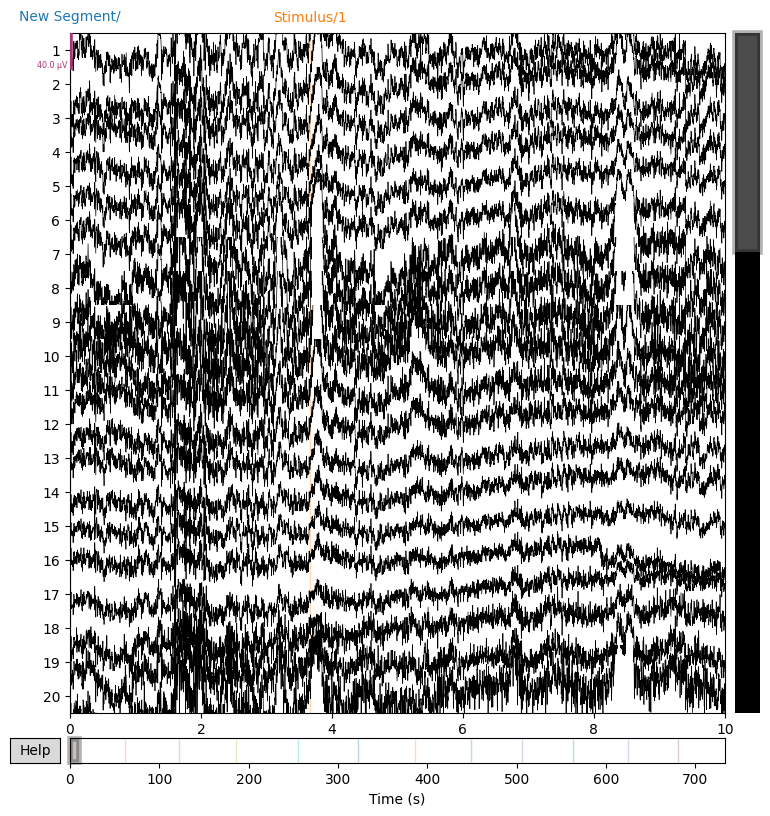

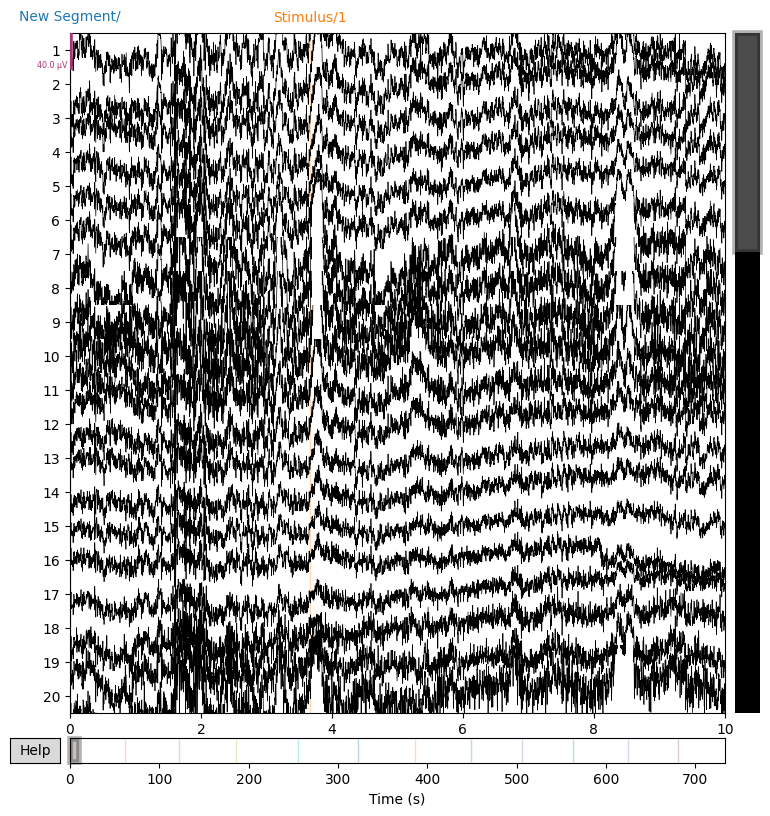

In [ ]:
example_eeg.plot()

### proc files

The processing files are `.mat` files, which can be read using `scipy.io.loadmat`. There is quite a bit of information in them...

In [ ]:
def check_items(dictionary):
    for k, v in dictionary.items():
        k_pretty = f'{k:<12}'
        v_pretty = f'{str(type(v)):<24}'
        if isinstance(v, dict):
            print('-'*80)
            print(k_pretty, v_pretty, v.keys(), sep='\t')
            check_items(v)
        elif isinstance(v, np.ndarray):
            if np.max(v.shape) < 10:
                print(k_pretty, v_pretty, v.shape, v, sep='\t')
            else:
                print(k_pretty, v_pretty, v.shape, v[0], sep='\t')
        else:
            print(k_pretty, v_pretty, v, sep='\t')

In [ ]:
example_proc = scipy.io.loadmat(
    os.path.join(PPROC_PATH, 'S11.mat'),
    squeeze_me=True,
    chars_as_strings=True,
    struct_as_record=True,
    simplify_cells=True,
)

print("Checking Items...")
check_items(example_proc)

print("\nChecking Bad Channels...")
bad_channels = list(example_proc['proc']['impedence']['bads'])
bad_channels += list(example_proc['proc']['rejections']['badchans'])
bad_channels = sorted(list(set(bad_channels)))
print(f"Bad channels: {bad_channels}")
print(f"TotCh - BadCh: {example_proc['proc']['tot_chans'] - len(bad_channels)}")
print(example_proc['proc']['ica']['unmixing'].shape)

Checking Items...
__header__  	<class 'bytes'>         	b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Nov 20 13:10:19 2018'
__version__ 	<class 'str'>           	1.0
__globals__ 	<class 'list'>          	[]
--------------------------------------------------------------------------------
proc        	<class 'dict'>          	dict_keys(['implicitref', 'refchannels', 'subject', 'dataset', 'trl', 'varnames', 'tot_trials', 'tot_chans', 'impedence', 'rejections', 'ica', 'rank'])
implicitref 	<class 'str'>           	29
refchannels 	<class 'numpy.ndarray'> 	(2,)	['25' '29']
subject     	<class 'str'>           	S11
dataset     	<class 'numpy.ndarray'> 	(0,)	[]
trl         	<class 'numpy.ndarray'> 	(2129, 6)	[ 6.02e+03  6.67e+03 -1.50e+02  1.00e+00  4.60e-02  1.00e+00]
varnames    	<class 'numpy.ndarray'> 	(3,)	['segment' 'tmin' 'Order']
tot_trials  	<class 'int'>           	2129
tot_chans   	<class 'int'>           	61
---------------------------------------------------------------

Note:
- The number of `proc.tot_trials` should be the same as the length of `proc.trl`
- We need to check why the number of channels is 61 but the number of channels in the EEG is 62. There are two channels in the EEG labeled `['VEOG', 'AUD']` so this may have something to do with it.
- Both `impedence` and `rejections` provide information on "bad channels" that should be excluded from analysis.
- It is unclear what the unmixing matrix does. Meta does not appear to use it. However, it may be important for removing noise from the EEG signal (see, e.g., [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6427454/)). The shape of `tot_channels - bad_channels` is close to the shape of the `example_proc['proc']['ica']['unmixing']` but unclear if this is just a coincidence. However, given that the VEOG and AUD channels exist, the difference could be because these channels do not require unmixing. From some research (as well as the description in the Brennan dataset [README](https://deepblue.lib.umich.edu/data/concern/data_sets/bn999738r?locale=en#read_me_display), the unmixing matrix corresponds to an Independent Component Analysis (ICA) unmixing matrix, which can be used to transform the raw EEG data into independent components. MNE has a function `mne.preprocessing.ICA` with method `apply` that can use an unmixing matrix ([documentation](https://mne.tools/stable/generated/mne.preprocessing.ICA.html)).

# CLIP
https://github.com/OpenAI/CLIP

# Planning Ahead

The dataset class will need to be able to read in the EEG data as we do above, apply preprocessing, retrieve the audio data and align it to the EEG data, and return the speech representations. It must also facilitate the sampling process for contrastive loss.